# Building a non-linear gravity inversion from scratch (almost)

In this notebook, we'll build a non-linear gravity inversion to estimate the relief of a sedimentary basin. We'll implement smoothness regularization and see its effects on the solution. We'll also see how we can break the inversion by adding random noise, abusing regularization, and breaking the underlying assumptions.

## Imports

We'll use the basic scientific Python stack for this tutorial plus a custom module with the forward modelling function (based on the code from the [Harmonica](https://github.com/fatiando/harmonica) library).

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cheatcodes as cc 

This is a little trick to make the resolution of the matplotlib figures better for larger screens.

In [2]:
plt.rc("figure", dpi=120)

## Assumptions

Here are some assumptions we'll work with:

1. The basin is much larger in the y-dimension so we'll assume it's infinite (reducing the problem to 2D)
1. The gravity disturbance is entirely due to the sedimentary basin
1. The top of the basin is a flat surface at $z=0$
1. The data are measured at a constant height of $z=1\ m$

## Making synthetic data

First, we'll explore the forward modelling function and create some synthetic data.

In [3]:
depths, basin_boundaries = cc.synthetic_model()

print(basin_boundaries)
print(depths)

(0, 100000.0)
[  10.10105917   18.81092435   29.38998081   42.16839388   57.51774684
   75.85246428   97.63037844  123.35222519  153.55985009  188.83290654
  229.78383989  277.05097454  331.28955675  393.1606554   463.31788573
  542.39199706  630.97345373  729.59323554  838.70218841  958.64936255
 1089.65988011 1231.81297121 1385.02090173 1549.00958058 1723.30167502
 1907.20307243 2099.79350393 2299.92208393 2506.20842163 2717.04982321
 2930.63493217 3144.96395261 3357.87537423 3567.07887609 3770.19383914
 3964.79265602 4148.44780248 4318.78143888 4473.51615424 4610.52535757
 4727.88177002 4823.90248153 4897.18910944 4946.66173395 4971.58548322
 4971.58889307 4946.67346668 4897.21419639 4823.95117457 4727.97279851
 4610.69145219 4473.81290687 4319.30099926 4149.33939015 3966.2923388
 3772.66640115 3571.07472151 3364.2050895  3154.79214739 2945.59306685
 2739.36473798 2538.83917762 2346.69270631 2165.50377716 1997.6945141
 1845.45234455 1710.63077305 1594.63228888 1498.28126903 1421.699

Plot the model.

<AxesSubplot:xlabel='x [km]', ylabel='depth [km]'>

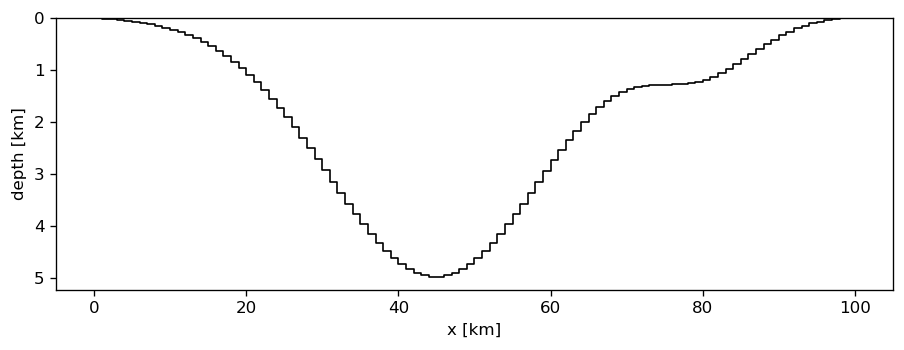

In [4]:
cc.plot_prisms(depths, basin_boundaries)

Forward model some gravity data at a set of locations.

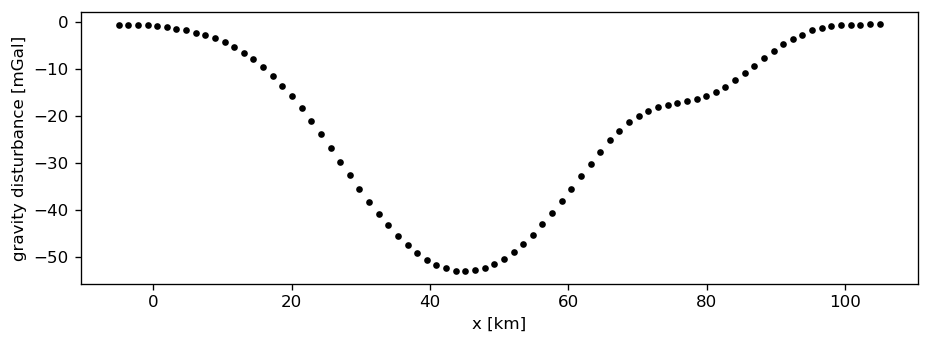

In [5]:
x = np.linspace(-5e3, 105e3, 80)
density = -300  # kg/m³
data = cc.forward_model(depths, basin_boundaries, density, x)

plt.figure(figsize=(9, 3))
plt.plot(x / 1000, data, ".k")
plt.xlabel("x [km]")
plt.ylabel("gravity disturbance [mGal]")
plt.show()

## Calculating the Jacobian matrix

The first step to most inverse problems is being able to calculate the Jacobian matrix. We'll do this for our problem by a first-order finite differences approximation. If you can get analytical derivatives, that's usually a lot better.

In [6]:
def make_jacobian(parameters, basin_boundaries, density, x):
    """
    Calculate the Jacobian matrix by finite differences.
    """
    jacobian = np.empty((x.size, parameters.size))
    step = np.zeros_like(parameters)
    delta = 10
    for j in range(jacobian.shape[1]):
        step[j] += delta
        jacobian[:, j] = (
            (
                cc.forward_model(parameters + step, basin_boundaries, density, x)
                - cc.forward_model(parameters, basin_boundaries, density, x)
            ) 
            / delta
        )
        step[j] = 0
    return jacobian

Calculate and plot an example so we can see what this matrix looks like. We'll use a parameter vector with constant depths at first.

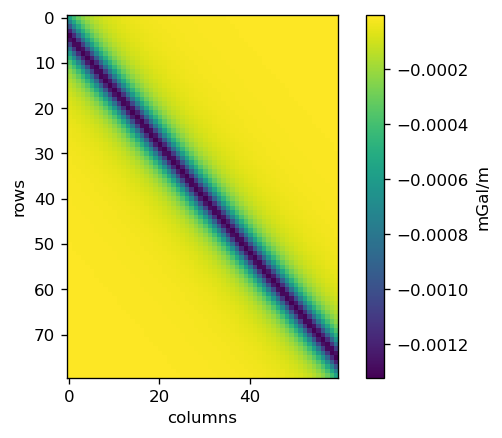

In [7]:
parameters = np.zeros(60) + 5000

jacobian = make_jacobian(parameters, basin_boundaries, density, x)

plt.figure()
plt.imshow(jacobian)
plt.colorbar(label="mGal/m")
plt.xlabel("columns")
plt.ylabel("rows")
plt.show()

## Solve the inverse problem 

Now that we have a way of forward modelling and calculating the Jacobian matrix, we can implement the Gauss-Newton method for solving the non-linear inverse problem. The function below takes the input data, model configuration, and an initial estimate and outputs the estimated parameters, data predicted by the final estimate, and a list with the goal function value per iteration. 

In [8]:
def basin2d_inversion(x, data, basin_boundaries, density, initial, max_iterations=10):
    """
    Solve the inverse problem using the Gauss-Newton method.
    """
    parameters = initial.astype(np.float64).copy() 
    predicted = cc.forward_model(parameters, basin_boundaries, density, x)
    residuals = data - predicted
    goal_function = [np.linalg.norm(residuals)**2]
    for i in range(max_iterations):       
        jacobian = make_jacobian(parameters, basin_boundaries, density, x)
        hessian = jacobian.T @ jacobian
        gradient = jacobian.T @ residuals
        deltap = np.linalg.solve(hessian, gradient)
        new_parameters = parameters + deltap
        predicted = cc.forward_model(new_parameters, basin_boundaries, density, x)
        residuals = data - predicted
        current_goal = np.linalg.norm(residuals)**2
        if current_goal > goal_function[-1]:
            break
        parameters = new_parameters
        goal_function.append(current_goal)
    return parameters, predicted, goal_function

Now we can use this function to invert our synthetic data.

In [13]:
estimated, predicted, goal_function = basin2d_inversion(
    x, data, basin_boundaries, density, initial=np.full(50, 1000),
)

Plot the observed vs predicted data so we can inspect the fit.

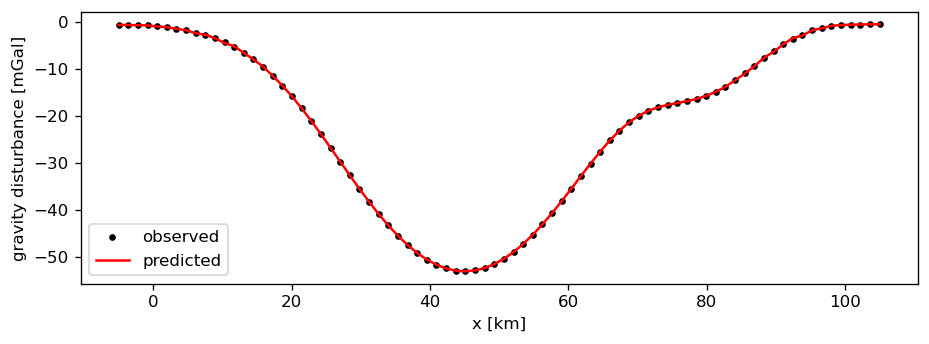

In [14]:
plt.figure(figsize=(9, 3))
plt.plot(x / 1e3, data, ".k", label="observed")
plt.plot(x / 1e3, predicted, "-r", label='predicted')
plt.legend()
plt.xlabel("x [km]")
plt.ylabel("gravity disturbance [mGal]")
plt.show()

Look at the convergence of the method.

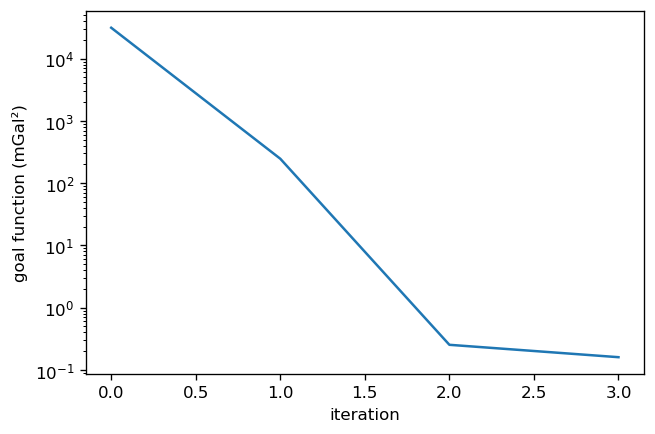

In [15]:
plt.figure()
plt.plot(goal_function)
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("goal function (mGal²)")
plt.show()

And finally see if our estimate is close to the true model.

<AxesSubplot:xlabel='x [km]', ylabel='depth [km]'>

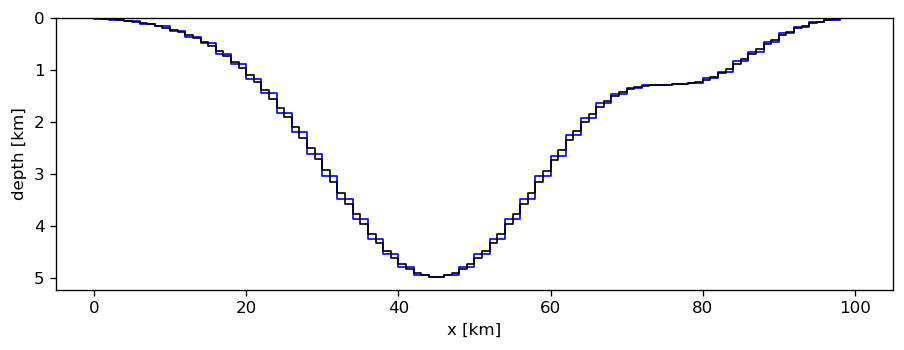

In [16]:
ax = cc.plot_prisms(estimated, basin_boundaries, edgecolor="blue")
cc.plot_prisms(depths, basin_boundaries, ax=ax)

Perfect! It seems that our inversion works well under these conditions (this initial estimate and no noise in the data). **Now let's break it!**

## **Flex your coding muscles**

**Add pseudo-random noise to the data using `np.random.normal` function and investigate the effect this has on the inversion results.** A typical gravity survey has accuracy in between 0.5-1 mGal. 

## **Question time!**

**Why does the inversion struggle to recover the deeper portions of the model in particular?**

Hint: It's related to the physics of the forward modelling and Jacobian matrix.

## Regularization to the rescue

To deal with the instability issues we encountered, we will apply **first-order Tikhonov regularization** (aka "smoothness"). 

## Can our inversion recover a fault?

## Sources of uncertainty
